<a href="https://colab.research.google.com/github/cpng123/Database-Advanced-Data-Techniques/blob/main/Lectures/13%20Deep%20Neural%20Networks/Hands-On%20Lab%3A%20Deep%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hands-On Lab: Deep Neural Networks**

## **1. Introduction & Universal Workflow**

In this notebook, we’ll demonstrate:

1. The **universal workflow** of machine learning:
   1. Define problem & gather data  
   2. Choose metrics of success (including F1 for imbalanced data)  
   3. Choose an evaluation protocol  
   4. Prepare data (Bag-of-Words/TF-IDF for IMDB, flatten for Fashion MNIST)  
   5. Build a **baseline** model (better than random)  
   6. **Scale up** → intentionally overfit  
   7. **Regularize** (Dropout, L2)  
   8. **Hyperparameter tuning** with **Hyperband**  

2. **Binary Classification** on **IMDB** reviews:
   - **Bag-of-Words** / **TF-IDF** approach (using `sklearn.feature_extraction`)  
   - **F1 score** for evaluation (since IMDB can be slightly imbalanced)  
   - Also demonstrate **class weights**.

3. **Multi-Class Classification** on **Fashion MNIST** (10 clothing classes).

4. **Appendix**:
   - EarlyStopping demonstration  
   - Why you might still want other forms of regularization even if you have EarlyStopping.

Let’s begin!

In [1]:
###########################################################
# 1.1 SETUP & IMPORTS
###########################################################
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Keras Tuner for hyperparameter search
!pip install -q -U keras-tuner
import keras_tuner as kt

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

print("TensorFlow version:", tf.__version__)
print("Keras Tuner version:", kt.__version__)

def plot_history(history, title=''):
    """
    Plot training/validation loss & accuracy from a Keras history object.
    Helps visualize overfitting/underfitting.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Val Loss')
    ax1.set_title(f'{title} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
    ax2.set_title(f'{title} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

print("""
UNIVERSAL WORKFLOW STEPS:
1) Define problem & gather data
2) Choose metrics (accuracy, F1, etc.)
3) Choose evaluation protocol
4) Prepare data (Bag-of-Words/TF-IDF for IMDB, flatten for Fashion MNIST)
5) Baseline model
6) Scale up -> Overfit
7) Regularize
8) Hyperparameter Tuning
(Appendix) EarlyStopping demonstration
""")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.6 MB/s eta 0:00:00
TensorFlow version: 2.17.1
Keras Tuner version: 1.4.7

UNIVERSAL WORKFLOW STEPS:
1) Define problem & gather data
2) Choose metrics (accuracy, F1, etc.)
3) Choose evaluation protocol
4) Prepare data (Bag-of-Words/TF-IDF for IMDB, flatten for Fashion MNIST)
5) Baseline model
6) Scale up -> Overfit
7) Regularize
8) Hyperparameter Tuning
(Appendix) EarlyStopping demonstration



# **2. Binary Classification: IMDB (with Bag-of-Words/TF-IDF and F1)**

Traditionally, IMDB can be processed via:
- **Multi-hot**: A naive bag-of-words approach.  
- **CountVectorizer** or **TfidfVectorizer** from **scikit-learn**: A more standard approach.  

We’ll do **TF-IDF** by default, but you can switch to **CountVectorizer** if desired.  

We’ll measure:
- **Accuracy** (baseline)  
- **F1 score** for imbalanced data.  

We’ll also use **class weights** to emphasize the minority class if any imbalance is present.

---

## 2.1 Define Problem & Load Data

In [2]:
###########################################################
# 2.1 IMDB DATA
###########################################################
num_words = 10000
(x_train_raw, y_train_raw), (x_test_raw, y_test_raw) = keras.datasets.imdb.load_data(num_words=num_words)

print("IMDB train samples:", len(x_train_raw))
print("IMDB test samples:", len(x_test_raw))

unique, counts = np.unique(y_train_raw, return_counts=True)
print("IMDB train label distribution:", dict(zip(unique, counts)))

classes = dict(zip(unique, counts))
print("Naive Baseline (Accuracy):", max([classes[0], classes[1]]) / (classes[0] + classes[1]))

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
IMDB train samples: 25000
IMDB test samples: 25000
IMDB train label distribution: {0: 12500, 1: 12500}
Naive Baseline (Accuracy): 0.5


### 2.2 Choose Metrics: Accuracy + F1
We’ll compute **accuracy** in Keras, and **F1** *after* training using `sklearn.metrics.f1_score`. We can also do a confusion matrix.



### 2.3 Evaluation Protocol
We’ll hold out 20% from the official training set for validation. Then we keep the official test set for the final check.

### 2.4 Data Preparation: Decoding to Text & TF-IDF

Keras IMDB is integer-encoded. We’ll:
1. Decode integers to text strings.  
2. Use **TfidfVectorizer** (or **CountVectorizer**) from scikit-learn.  
3. Convert to **dense arrays** (since Keras typically needs dense input).  

Finally, we’ll define class weights.

In [3]:
###########################################################
# 2.4 BAG-OF-WORDS / TF-IDF FOR IMDB
###########################################################
# Retrieve word index from Keras
word_index = keras.datasets.imdb.get_word_index()

# Reverse mapping (integer -> word)
reverse_word_index = {v: k for (k, v) in word_index.items()}
# Indices 0..3 are special tokens in Keras IMDB
def decode_review(int_seq):
    return " ".join([reverse_word_index.get(i-3, "?") for i in int_seq])

# Convert integer sequences to raw text
train_texts = [" ".join([reverse_word_index.get(i-3, "?") for i in seq]) for seq in x_train_raw]
test_texts  = [" ".join([reverse_word_index.get(i-3, "?") for i in seq]) for seq in x_test_raw]

# Use TfidfVectorizer or CountVectorizer
# vectorizer = CountVectorizer(max_features=num_words, stop_words='english')
vectorizer = TfidfVectorizer(max_features=num_words, stop_words='english')

X_train_sparse = vectorizer.fit_transform(train_texts)
X_test_sparse  = vectorizer.transform(test_texts)

# Convert sparse -> dense (can be memory-heavy; consider partial approaches for large data)
X_train = X_train_sparse.toarray()
X_test  = X_test_sparse.toarray()

y_train = y_train_raw
y_test  = y_test_raw

print("TF-IDF train shape:", X_train.shape)
print("TF-IDF test shape: ", X_test.shape)

# Class weighting （For imbalance dataset only, in this case, the dataset is balance, so it doesn't really need this part)
unique, counts = np.unique(y_train, return_counts=True)
neg_count, pos_count = counts[0], counts[1]
total_count = neg_count + pos_count
weight_for_0 = (1.0 / neg_count) * (total_count / 2.0)
weight_for_1 = (1.0 / pos_count) * (total_count / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}
print("IMDB class weights:", class_weights)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
TF-IDF train shape: (25000, 9477)
TF-IDF test shape:  (25000, 9477)
IMDB class weights: {0: 1.0, 1: 1.0}


In [4]:
# Split out some of the training set for validation
X_train_imdb, X_val_imdb, y_train_imdb, y_val_imdb = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print("Train samples after splitting:", X_train_imdb.shape[0])
print("Validation samples:", X_val_imdb.shape[0])

Train samples after splitting: 20000
Validation samples: 5000


## 2.5 Baseline Model (Single-Layer Perceptron)

We do a single `Dense(1, sigmoid)`. We measure **accuracy** during training, and after training we’ll compute the **F1** on the validation set (and test set).

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7138 - loss: 0.6710 - val_accuracy: 0.8462 - val_loss: 0.6101
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8713 - loss: 0.5867 - val_accuracy: 0.8538 - val_loss: 0.5491
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8782 - loss: 0.5248 - val_accuracy: 0.8560 - val_loss: 0.5031
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8864 - loss: 0.4758 - val_accuracy: 0.8606 - val_loss: 0.4673
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8903 - loss: 0.4390 - val_accuracy: 0.8638 - val_loss: 0.4390


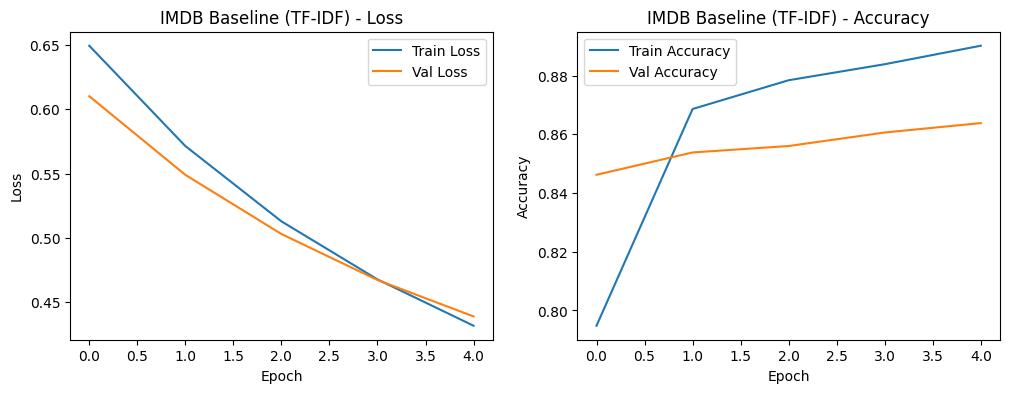

Baseline Test Accuracy: 0.8646
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Baseline Test F1 score: 0.8646


In [5]:
###########################################################
# 2.5 BASELINE MODEL
###########################################################
baseline_model = keras.Sequential([
    layers.Dense(1, activation='sigmoid', input_shape=(X_train_imdb.shape[1],))
])

baseline_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_base = baseline_model.fit(
    X_train_imdb, y_train_imdb,
    validation_data=(X_val_imdb, y_val_imdb),
    epochs=5,
    batch_size=32,
    class_weight=class_weights, # This line is for imbalance dataset
    verbose=1
)

plot_history(history_base, "IMDB Baseline (TF-IDF)")

# Evaluate on test
test_loss_base, test_acc_base = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"Baseline Test Accuracy: {test_acc_base:.4f}")

# Let's also compute F1 on test
y_test_preds_base = (baseline_model.predict(X_test) > 0.5).astype(int).ravel()
test_f1_base = f1_score(y_test, y_test_preds_base)
print(f"Baseline Test F1 score: {test_f1_base:.4f}")

## 2.6 Overfit (More Layers)

We add more layers/units. We expect training accuracy to rise, but if we do enough epochs, the validation might degrade. We’ll measure both accuracy and F1 after training.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.7471 - loss: 0.6328 - val_accuracy: 0.8692 - val_loss: 0.3419
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9133 - loss: 0.2504 - val_accuracy: 0.8846 - val_loss: 0.2859
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9515 - loss: 0.1419 - val_accuracy: 0.8808 - val_loss: 0.3144
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9726 - loss: 0.0988 - val_accuracy: 0.8718 - val_loss: 0.3632
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9827 - loss: 0.0697 - val_accuracy: 0.8622 - val_loss: 0.4266
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9915 - loss: 0.0460 - val_accuracy: 0.8592 - val_loss: 0.4867
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9965 - loss: 0.0286 - val_accuracy: 0.8570 - val_loss: 0.5487
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9984 - loss: 0.0190 - val_accuracy: 0.8530 - v

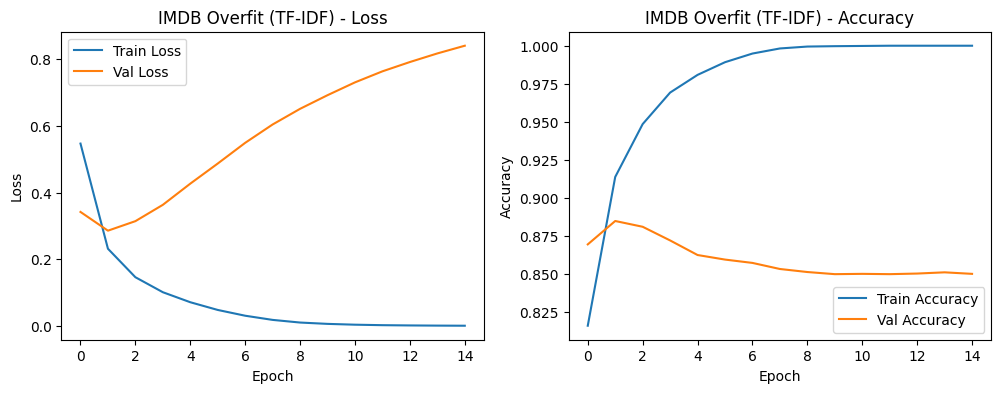

Overfit Model Test Accuracy: 0.8302
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Overfit Model Test F1: 0.8270


In [6]:
overfit_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_imdb.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

overfit_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_overfit = overfit_model.fit(
    X_train_imdb, y_train_imdb,
    validation_data=(X_val_imdb, y_val_imdb),
    epochs=15,
    batch_size=512,
    class_weight=class_weights,
    verbose=1
)

plot_history(history_overfit, "IMDB Overfit (TF-IDF)")

# Evaluate on test
test_loss_over, test_acc_over = overfit_model.evaluate(X_test, y_test, verbose=0)
print(f"Overfit Model Test Accuracy: {test_acc_over:.4f}")

y_test_preds_over = (overfit_model.predict(X_test) > 0.5).astype(int).ravel()
test_f1_over = f1_score(y_test, y_test_preds_over)
print(f"Overfit Model Test F1: {test_f1_over:.4f}")

## 2.7 Regularize (Dropout + L2) + F1

Dropout and L2 penalize large weights and randomize neuron outputs, hopefully improving generalization. We’ll check both accuracy and F1.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.6513 - loss: 0.8764 - val_accuracy: 0.8538 - val_loss: 0.6106
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8637 - loss: 0.5547 - val_accuracy: 0.8836 - val_loss: 0.4526
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9051 - loss: 0.4170 - val_accuracy: 0.8782 - val_loss: 0.4413
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9218 - loss: 0.3840 - val_accuracy: 0.8848 - val_loss: 0.4389
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9320 - loss: 0.3579 - val_accuracy: 0.8796 - val_loss: 0.4438
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9390 - loss: 0.3448 - val_accuracy: 0.8812 - val_loss: 0.4428
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9434 - loss: 0.3279 - val_accuracy: 0.8784 - val_loss: 0.4469
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9437 - loss: 0.3213 - val_accuracy: 0.8748 - v

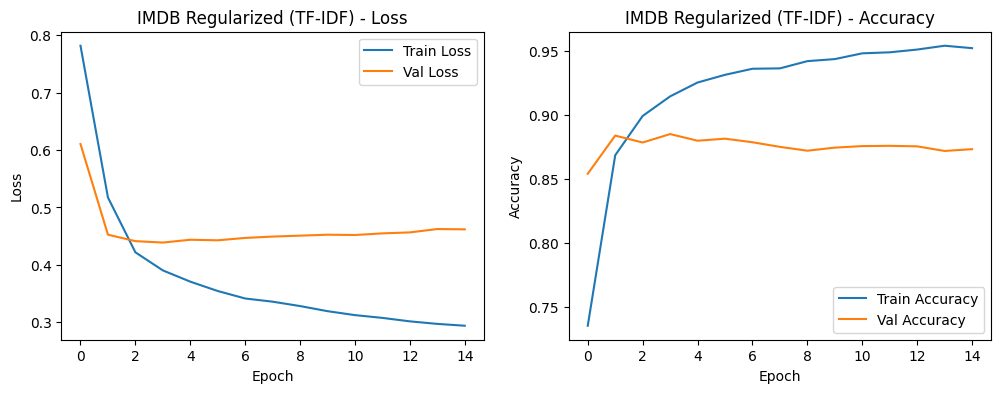

Regularized Model Test Accuracy: 0.8624
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Regularized Model Test F1: 0.8613


In [7]:
reg_model = keras.Sequential([
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train_imdb.shape[1],)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

reg_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_reg = reg_model.fit(
    X_train_imdb, y_train_imdb,
    validation_data=(X_val_imdb, y_val_imdb),
    epochs=15,
    batch_size=512,
    class_weight=class_weights,
    verbose=1
)

plot_history(history_reg, "IMDB Regularized (TF-IDF)")

# Evaluate test
test_loss_reg, test_acc_reg = reg_model.evaluate(X_test, y_test, verbose=0)
print(f"Regularized Model Test Accuracy: {test_acc_reg:.4f}")

y_test_preds_reg = (reg_model.predict(X_test) > 0.5).astype(int).ravel()
test_f1_reg = f1_score(y_test, y_test_preds_reg)
print(f"Regularized Model Test F1: {test_f1_reg:.4f}")

## 2.8 Hyperparameter Tuning (Hyperband)

We’ll define a tuner that tries different layer counts, dropout, L2, and learning rates. We’ll optimize for **validation accuracy** in Keras, but after we find the best model, we’ll also measure **F1** on the test set.

You can attempt to incorporate a custom F1-based objective. However, it’s simpler to just optimize accuracy in Keras, then compute F1 externally.

Trial 10 Complete [00h 00m 17s]
val_accuracy: 0.8496000170707703

Best val_accuracy So Far: 0.8858000040054321
Total elapsed time: 00h 02m 04s
Best hyperparams (IMDB): {'n_layers': 3, 'units_0': 128, 'l2_0': 0.00044489082371598814, 'drop_0': 0.4, 'lr': 0.0007725361104998666, 'units_1': 64, 'l2_1': 0.008623436067374464, 'drop_1': 0.4, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0, 'units_2': 64, 'l2_2': 0.0001, 'drop_2': 0.0}
Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.6244 - loss: 1.3929 - val_accuracy: 0.8536 - val_loss: 0.9963
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8654 - loss: 0.8779 - val_accuracy: 0.8844 - val_loss: 0.6125
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9202 - loss: 0.5290 - val_accuracy: 0.8862 - val_loss: 0.5077
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9424 - loss: 0.3905 - val_accuracy: 0.8790 - val_loss: 0.4651
Epoch 5/10
40/40 ━━━━━━━━━

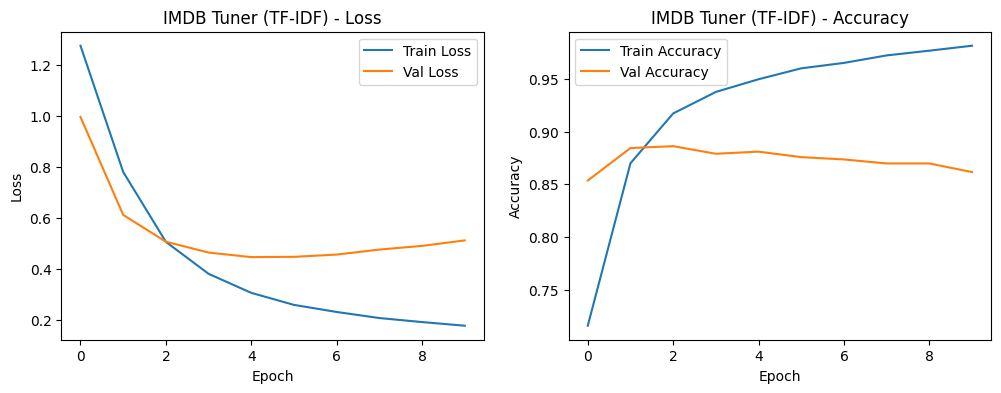

Tuned Model Test Accuracy: 0.8517
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Tuned Model Test F1 Score: 0.8517


In [8]:
def build_imdb_model_tuner(hp):
    model = keras.Sequential()

    n_layers = hp.Int('n_layers', 1, 3)
    for i in range(n_layers):
        units = hp.Choice(f'units_{i}', [64,128,256])
        l2_factor = hp.Float(f'l2_{i}', 1e-4, 1e-2, sampling='log')
        model.add(layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(l2_factor),
                               input_shape=(X_train_imdb.shape[1],) if i==0 else ()))
        drop = hp.Float(f'drop_{i}', 0.0, 0.5, step=0.1)
        model.add(layers.Dropout(drop))
    model.add(layers.Dense(1, activation='sigmoid'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner_imdb = kt.Hyperband(
    build_imdb_model_tuner,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='imdb_tfidf_hyperband',
    project_name='imdb_f1_demo'
)

tuner_imdb.search(
    X_train_imdb, y_train_imdb,
    validation_data=(X_val_imdb, y_val_imdb),
    epochs=5,
    batch_size=512,
    class_weight=class_weights
)

best_hp_imdb = tuner_imdb.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparams (IMDB):", best_hp_imdb.values)

best_model_imdb = tuner_imdb.hypermodel.build(best_hp_imdb)
history_imdb_tuned = best_model_imdb.fit(
    X_train_imdb, y_train_imdb,
    validation_data=(X_val_imdb, y_val_imdb),
    epochs=10,
    batch_size=512,
    class_weight=class_weights
)

plot_history(history_imdb_tuned, "IMDB Tuner (TF-IDF)")

# Evaluate final
test_loss_tuned, test_acc_tuned = best_model_imdb.evaluate(X_test, y_test, verbose=0)
print(f"Tuned Model Test Accuracy: {test_acc_tuned:.4f}")

y_test_preds_tuned = (best_model_imdb.predict(X_test) > 0.5).astype(int).ravel()
test_f1_tuned = f1_score(y_test, y_test_preds_tuned)
print(f"Tuned Model Test F1 Score: {test_f1_tuned:.4f}")

# **3. Multi-Class: Fashion MNIST**

We keep the previous approach for Fashion MNIST (flatten 28×28 images). We'll measure accuracy (and skip F1 because it's multi-class, though we could do macro/micro average F1).

In [9]:
###########################################################
# 3.1 LOAD FASHION MNIST
###########################################################
from tensorflow.keras.datasets import fashion_mnist
(x_train_fm, y_train_fm), (x_test_fm, y_test_fm) = fashion_mnist.load_data()

x_train_fm = x_train_fm / 255.0
x_test_fm  = x_test_fm  / 255.0

X_train_fm_flat = x_train_fm.reshape(-1, 28*28)
X_test_fm_flat  = x_test_fm.reshape(-1, 28*28)

print("FashionMNIST train shape:", x_train_fm.shape)
print("FashionMNIST test shape: ",  x_test_fm.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
FashionMNIST train shape: (60000, 28, 28)
FashionMNIST test shape:  (10000, 28, 28)


## 3.2 Baseline (Single-Layer)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7247 - loss: 0.8208 - val_accuracy: 0.8301 - val_loss: 0.4984
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8324 - loss: 0.4846 - val_accuracy: 0.8432 - val_loss: 0.4555
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8475 - loss: 0.4484 - val_accuracy: 0.8474 - val_loss: 0.4493
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8549 - loss: 0.4208 - val_accuracy: 0.8518 - val_loss: 0.4333
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8568 - loss: 0.4179 - val_accuracy: 0.8497 - val_loss: 0.4305


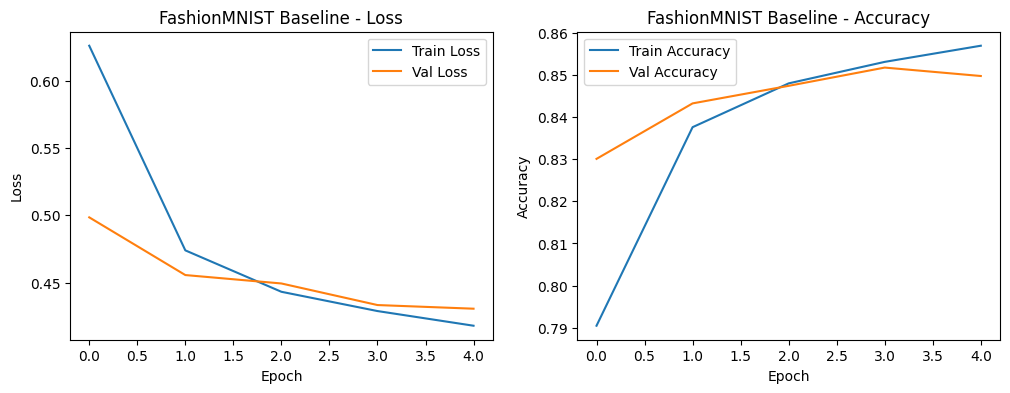

FashionMNIST Baseline Test Accuracy: 0.8405


In [10]:
baseline_fm = keras.Sequential([
    layers.Dense(10, activation='softmax', input_shape=(784,))
])
baseline_fm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fm_base = baseline_fm.fit(
    X_train_fm_flat, y_train_fm,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    verbose=1
)

plot_history(history_fm_base, 'FashionMNIST Baseline')
test_loss_fm_base, test_acc_fm_base = baseline_fm.evaluate(X_test_fm_flat, y_test_fm, verbose=0)
print(f"FashionMNIST Baseline Test Accuracy: {test_acc_fm_base:.4f}")

## 3.3 Overfit (More Layers)

**Compare different architecture too, dont have to be 128, 256**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.6838 - loss: 0.9734 - val_accuracy: 0.8403 - val_loss: 0.4590
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8456 - loss: 0.4366 - val_accuracy: 0.8575 - val_loss: 0.4003
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8642 - loss: 0.3803 - val_accuracy: 0.8533 - val_loss: 0.4142
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8731 - loss: 0.3567 - val_accuracy: 0.8689 - val_loss: 0.3590
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8793 - loss: 0.3333 - val_accuracy: 0.8728 - val_loss: 0.3538
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8882 - loss: 0.3080 - val_accuracy: 0.8767 - val_loss: 0.3403
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8889 - loss: 0.3019 - val_accuracy: 0.8820 - val_loss: 0.3282
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8973 - loss: 0.2843 - val_accuracy: 0.8827 - val_loss

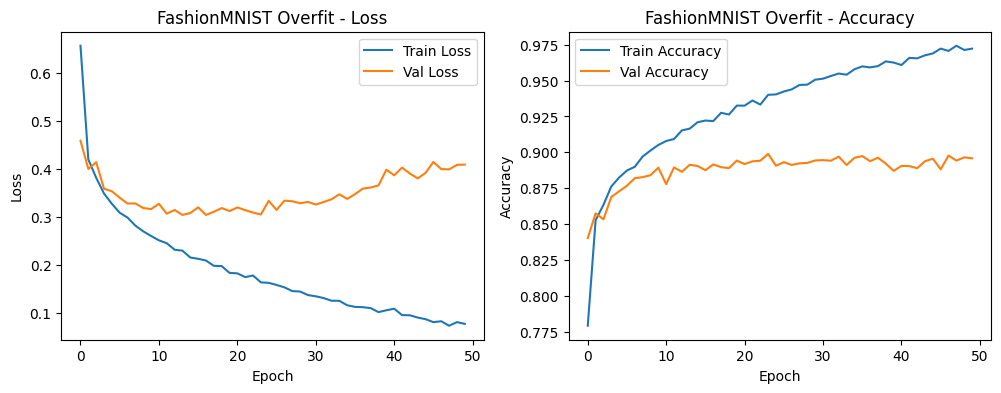

Overfit Model Test Accuracy: 0.8898


In [14]:
overfit_fm = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(784,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])
overfit_fm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_fm_over = overfit_fm.fit(
    X_train_fm_flat, y_train_fm,
    validation_split=0.2,
    epochs=50,
    batch_size=512,
    verbose=1
)

plot_history(history_fm_over, 'FashionMNIST Overfit')
test_loss_fm_over, test_acc_fm_over = overfit_fm.evaluate(X_test_fm_flat, y_test_fm, verbose=0)
print(f"Overfit Model Test Accuracy: {test_acc_fm_over:.4f}")

## 3.4 Regularize (Dropout + L2)

**Compare the dropout only, L2 only and both together.**

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5041 - loss: 1.8885 - val_accuracy: 0.8116 - val_loss: 0.9084
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7825 - loss: 0.9783 - val_accuracy: 0.8352 - val_loss: 0.7515
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8135 - loss: 0.8205 - val_accuracy: 0.8443 - val_loss: 0.6669
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8274 - loss: 0.7299 - val_accuracy: 0.8512 - val_loss: 0.6081
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8374 - loss: 0.6703 - val_accuracy: 0.8574 - val_loss: 0.5773
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8443 - loss: 0.6269 - val_accuracy: 0.8630 - val_loss: 0.5435
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8429 - loss: 0.6031 - val_accuracy: 0.8604 - val_loss: 0.5299
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8474 - loss: 0.5803 - val_accuracy: 0.8641 - val_loss

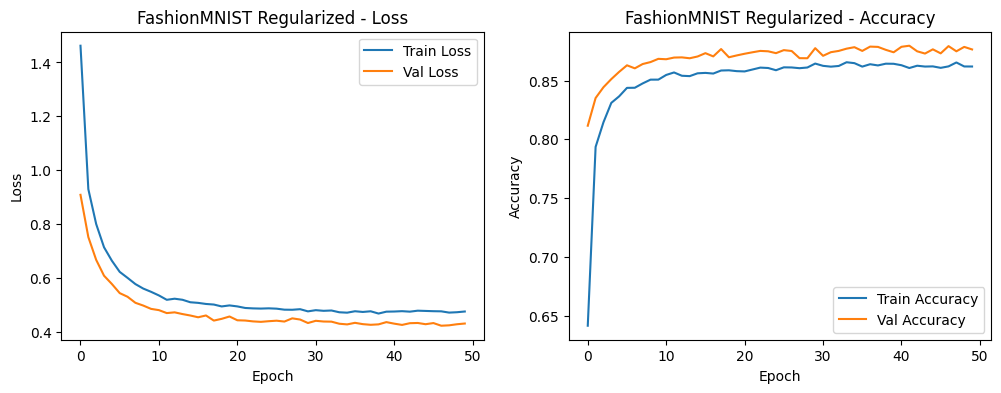

FashionMNIST Regularized Test Accuracy: 0.8676


In [15]:
reg_fm = keras.Sequential([
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(784,)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])
reg_fm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_fm_reg = reg_fm.fit(
    X_train_fm_flat, y_train_fm,
    validation_split=0.2,
    epochs=50,
    batch_size=512,
    verbose=1
)

plot_history(history_fm_reg, 'FashionMNIST Regularized')
test_loss_fm_reg, test_acc_fm_reg = reg_fm.evaluate(X_test_fm_flat, y_test_fm, verbose=0)
print(f"FashionMNIST Regularized Test Accuracy: {test_acc_fm_reg:.4f}")

## 3.5 Hyperparameter Tuning (Hyperband)

**RandomSearch , Hyperband , BayesianOptimization**

**Either from the three are from Keras, we can just pick anyone to use, also can just compare 3 of them**

Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.856333315372467

Best val_accuracy So Far: 0.8733333349227905
Total elapsed time: 00h 02m 21s
Best Hyperparams (Fashion MNIST): {'n_layers': 3, 'units_0': 256, 'l2_0': 0.0006820148289798281, 'drop_0': 0.30000000000000004, 'lr': 0.0007104416318148381, 'tuner/epochs': 5, 'tuner/initial_epoch': 2, 'tuner/bracket': 1, 'tuner/round': 1, 'units_1': 128, 'l2_1': 0.0001, 'drop_1': 0.0, 'units_2': 128, 'l2_2': 0.0001, 'drop_2': 0.0, 'tuner/trial_id': '0001'}
Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.5728 - loss: 1.4905 - val_accuracy: 0.8219 - val_loss: 0.7182
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8265 - loss: 0.7099 - val_accuracy: 0.8422 - val_loss: 0.6269
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8465 - loss: 0.6168 - val_accuracy: 0.8622 - val_loss: 0.5588
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8583 - loss: 0.5639 - val_accuracy: 0.8654 - val_loss: 

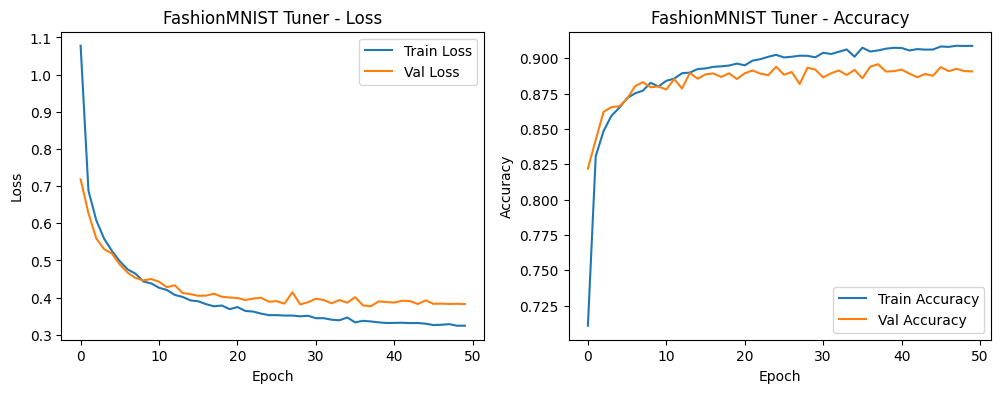

Tuned Model Test Accuracy: 0.8850


In [17]:
def build_fm_model_tuner(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(784,)))

    n_layers = hp.Int('n_layers', 1, 3)
    for i in range(n_layers):
        units = hp.Choice(f'units_{i}', [128, 256])
        l2_factor = hp.Float(f'l2_{i}', 1e-4, 1e-2, sampling='log')
        model.add(layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(l2_factor)))
        drop_rate = hp.Float(f'drop_{i}', 0.0, 0.5, step=0.1)
        model.add(layers.Dropout(drop_rate))

    model.add(layers.Dense(10, activation='softmax'))

    lr = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner_fm = kt.Hyperband(
    build_fm_model_tuner,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='fashion_hyperband',
    project_name='fm_tfidf_demo'
)

tuner_fm.search(
    X_train_fm_flat, y_train_fm,
    validation_split=0.2,
    epochs=32,
    batch_size=512
)

best_hp_fm = tuner_fm.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparams (Fashion MNIST):", best_hp_fm.values)

best_model_fm = tuner_fm.hypermodel.build(best_hp_fm)
history_fm_tuned = best_model_fm.fit(
    X_train_fm_flat, y_train_fm,
    validation_split=0.2,
    epochs=50,
    batch_size=512
)

plot_history(history_fm_tuned, "FashionMNIST Tuner")
test_loss_fm_tuned, test_acc_fm_tuned = best_model_fm.evaluate(X_test_fm_flat, y_test_fm, verbose=0)
print(f"Tuned Model Test Accuracy: {test_acc_fm_tuned:.4f}")

# **4. Appendix: EarlyStopping & Why Regularize Anyway?**

## 4.1 EarlyStopping Example + Plot

Below is how we might apply EarlyStopping for, say, the IMDB or FashionMNIST data. We can then see the training stops early to avoid overfitting. We’ll also plot the history to see how many epochs it trained.

Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6304 - loss: 1.1113 - val_accuracy: 0.8263 - val_loss: 0.5032
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8354 - loss: 0.4726 - val_accuracy: 0.8472 - val_loss: 0.4310
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8547 - loss: 0.4148 - val_accuracy: 0.8557 - val_loss: 0.4086
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8667 - loss: 0.3781 - val_accuracy: 0.8622 - val_loss: 0.3845
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8742 - loss: 0.3557 - val_accuracy: 0.8658 - val_loss: 0.3757
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8770 - loss: 0.3442 - val_accuracy: 0.8746 - val_loss: 0.3558
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8828 - loss: 0.3279 - val_accuracy: 0.8712 - val_loss: 0.3565
Epoch 8/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8878 - loss: 0.3102 - val_accuracy: 0.8772 - 

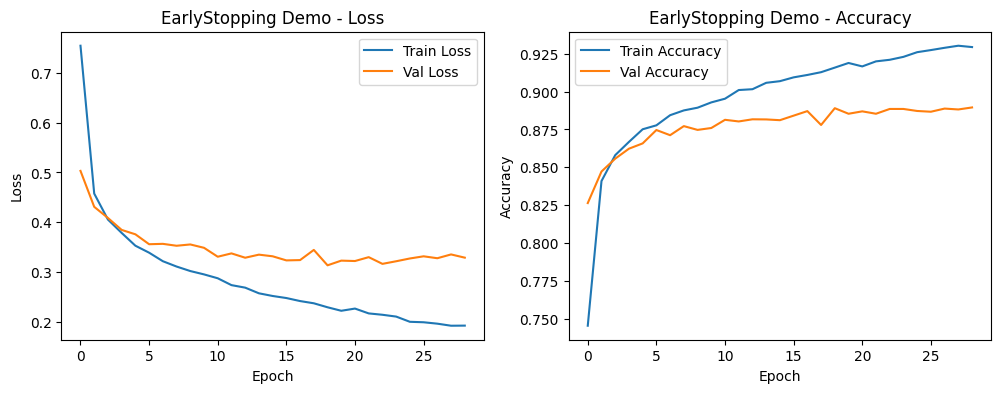

EarlyStopping Demo - Test Accuracy: 0.8818


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

model_es_demo = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model_es_demo.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history_es_demo = model_es_demo.fit(
    X_train_fm_flat, y_train_fm,
    validation_split=0.2,
    epochs=100,        # set a big number
    batch_size=512,
    callbacks=[early_stop]
)

# Plot
plot_history(history_es_demo, title="EarlyStopping Demo")

test_loss_es, test_acc_es = model_es_demo.evaluate(X_test_fm_flat, y_test_fm, verbose=0)
print(f"EarlyStopping Demo - Test Accuracy: {test_acc_es:.4f}")

## 4.2 If EarlyStopping is Enough, Why Bother with Regularization?

- **EarlyStopping** halts training when validation performance stops improving, preventing “late-stage overfitting.”
- However, you can still overfit **within** the earlier epochs. EarlyStopping only stops after some damage might be done.
- **Regularization** (like dropout, L2) actively shapes the learning trajectory from the start, often leading to **better** generalization and improved final metrics.
- Combining both:
  - Use L2/Dropout to reduce overfitting potential  
  - Use EarlyStopping to avoid extra epochs where no val improvement occurs  
  - Typically yields the **best** final results.

# **5. Observations & Further Improvements**

1. **IMDB with TF-IDF**:  
   - Replaces naive multi-hot, leading to more standard text features.  
   - We measured **F1** to handle potential class imbalance.  
   - Class weighting can also shift the decision boundary.  

2. **Fashion MNIST**:  
   - Flatten + Dense ~80% baseline.  
   - Overfit soared with big layers.  
   - Dropout + L2 improved generalization.  
   - Hyperband found better combos of hyperparams.  

3. **Hyperband** vs. RandomSearch**:  
   - Hyperband adaptively focuses on promising hyperparam sets, often converging faster.  